We will be using a pretrained DCGAN from the following implementation:
https://github.com/carpedm20/DCGAN-tensorflow

This has been trained on the CelebA dataset (~1.4 G): http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

Checkpoint: https://drive.google.com/open?id=1XnQp_DrmYdrB4k3AbJ56pUnuP4sQ-Wo8


In [4]:
import numpy as np
import tensorflow as tf
from model import DCGAN
import utils

INPUT_WIDTH = INPUT_HEIGHT = 108
BATCH_SIZE = 64

run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

# First lets output 128 generated faces,
# and keep the z vectors used to generate them
tf.reset_default_graph() 
with tf.Session(config=run_config) as sess:
    dcgan = DCGAN(sess,
                  input_width=INPUT_WIDTH,
                  input_height=INPUT_HEIGHT,
                  dataset_name='celebA',
                  crop=True)
    if not dcgan.load('checkpoint')[0]:
        print('Error loading checkpoint')
        
    z_samples = []
    samples = []
    for i in range(2):
        z_sample = np.random.uniform(-0.5, 0.5, size=(BATCH_SIZE, dcgan.z_dim))
        z_samples.append(z_sample)
        samples.append(sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample}))
    z_samples = np.vstack(z_samples)
    samples = utils.inverse_transform(np.vstack(samples))

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-128502
 [*] Success to read DCGAN.model-128502


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

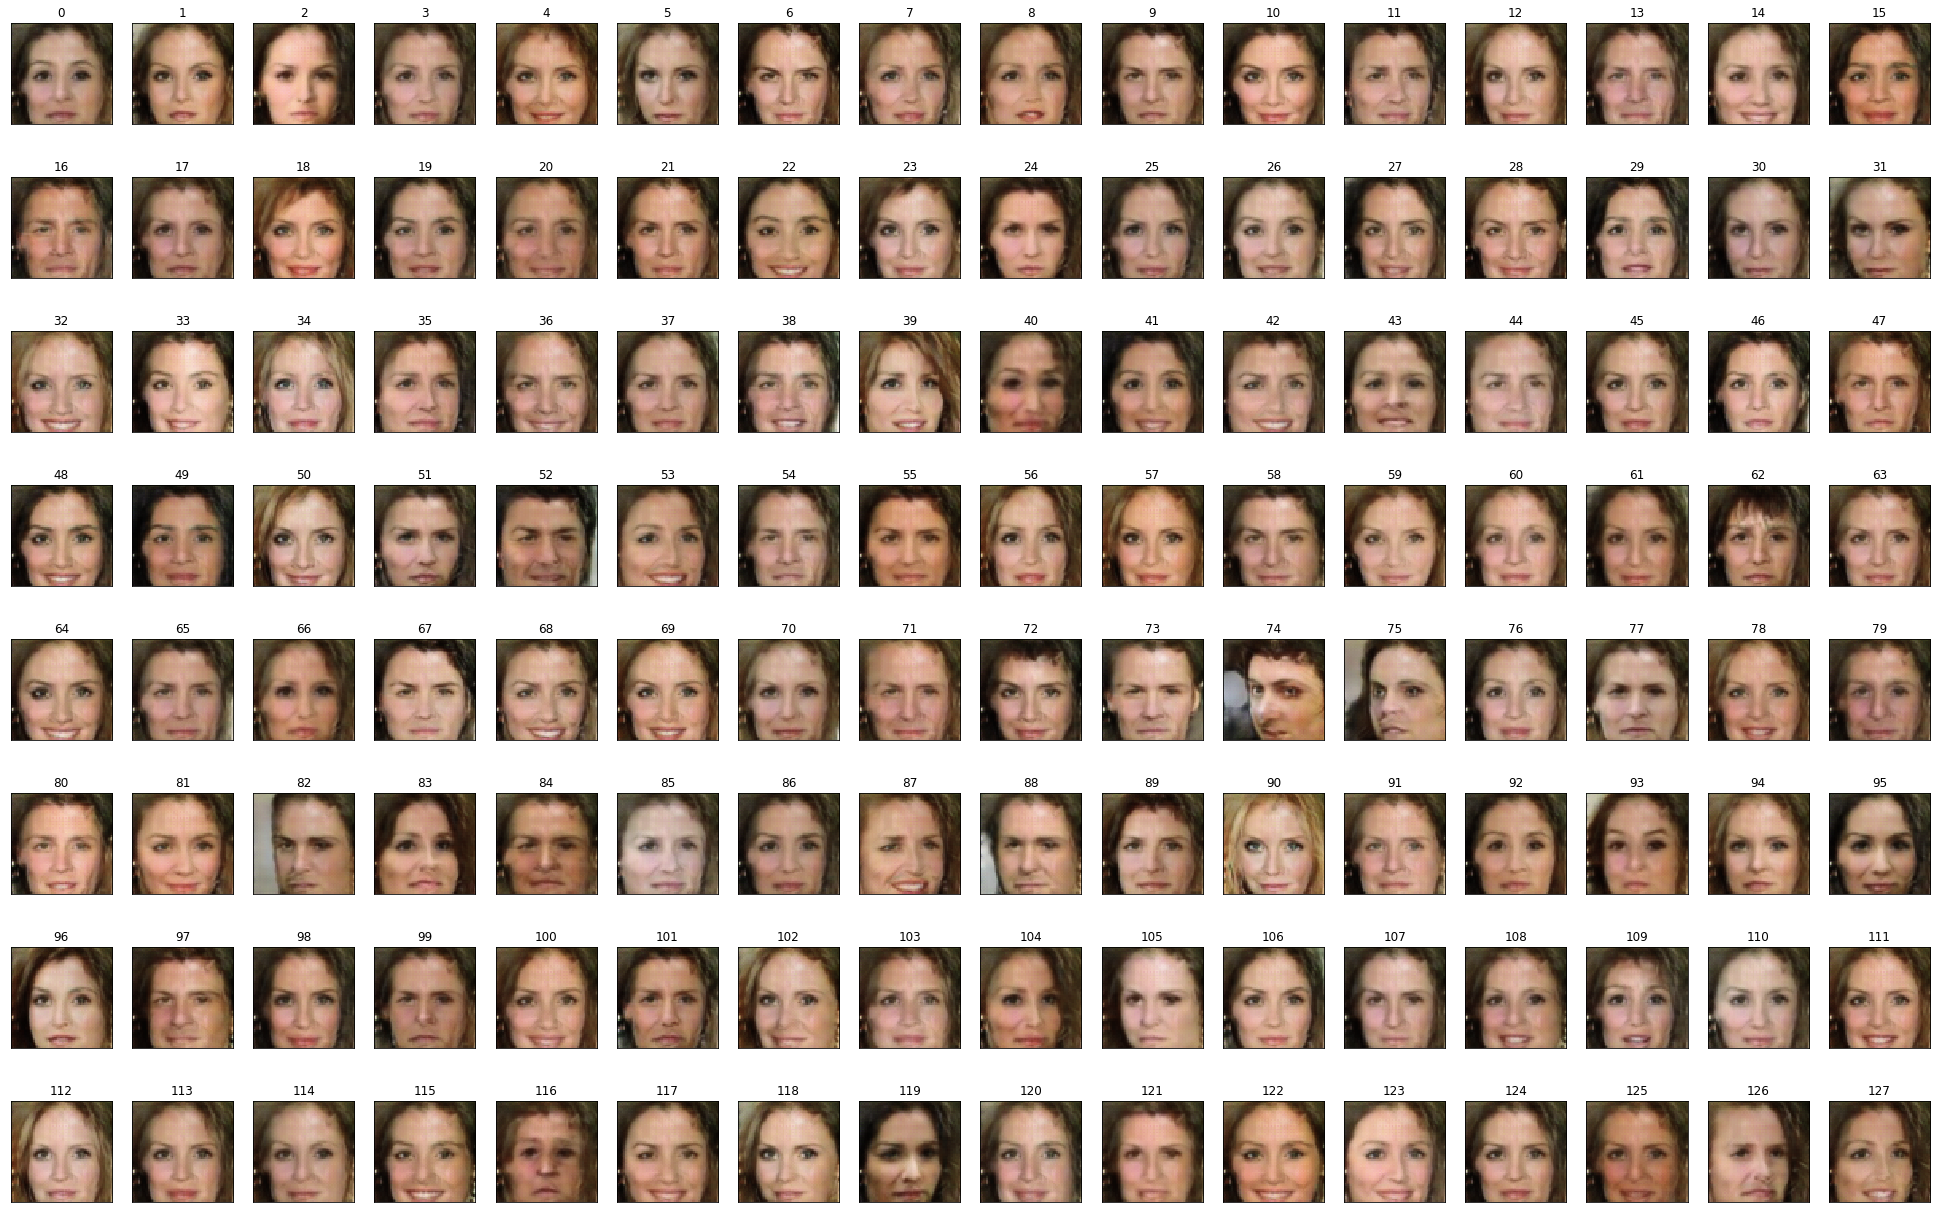

In [6]:
# View generated face
plot_gallery(samples, range(128), 8, 16)

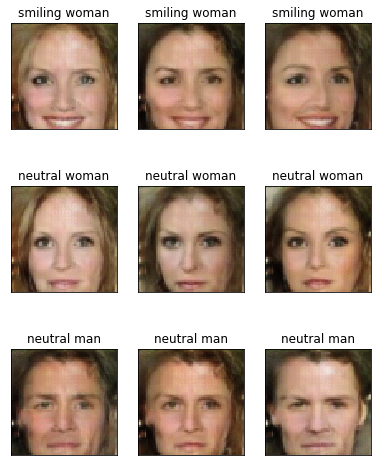

In [20]:
# Get z vectors containing concepts we want
smiling_woman_indices = [32, 117, 53]
neutral_woman_indices = [112, 5, 1]
neutral_man_indices = [16, 47, 73]


indices = smiling_woman_indices + neutral_woman_indices + neutral_man_indices
titles = ['smiling woman'] * 3 + ['neutral woman'] * 3 + ['neutral man'] * 3
plot_gallery([samples[i] for i in indices], titles, 3, 3)

In [21]:
# Get means of each, according to DCGAN paper, 1 vector is unstable and the mean of 3 are needed
smiling_woman = np.mean([z_samples[i] for i in smiling_woman_indices], axis=0)
neutral_woman = np.mean([z_samples[i] for i in neutral_woman_indices], axis=0)
neutral_man = np.mean([z_samples[i] for i in neutral_man_indices], axis=0)

# Do some arithmetic, then add some jitter to y
y = smiling_woman - neutral_woman + neutral_man
y_grid = np.tile(y, (BATCH_SIZE, 1))
y_grid += np.random.uniform(-0.25, 0.25, y_grid.shape)

In [22]:
# Now run y through generator
tf.reset_default_graph() 
with tf.Session(config=run_config) as sess:
    dcgan = DCGAN(sess,
                  input_width=INPUT_WIDTH,
                  input_height=INPUT_HEIGHT,
                  dataset_name='celebA',
                  crop=True)
    if not dcgan.load('checkpoint')[0]:
        print('Error loading checkpoint')
        
    smiling_man = utils.inverse_transform(sess.run(dcgan.sampler, feed_dict={dcgan.z: y_grid}))

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-128502
 [*] Success to read DCGAN.model-128502


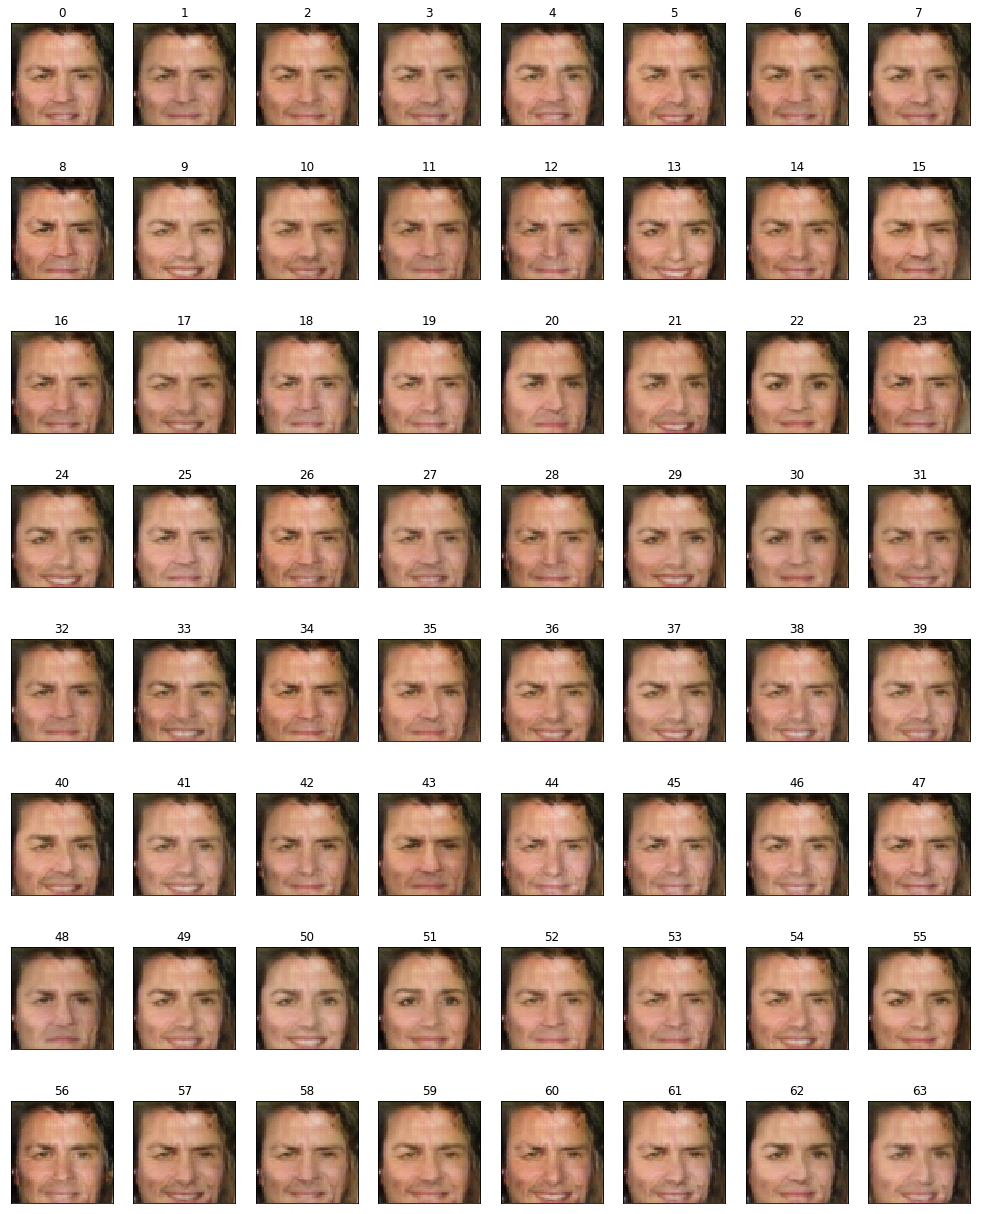

In [23]:
plot_gallery(smiling_man, range(64), 8, 8)